In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
mat = loadmat("ex3data1.mat")
X = mat["X"]
y = mat["y"]

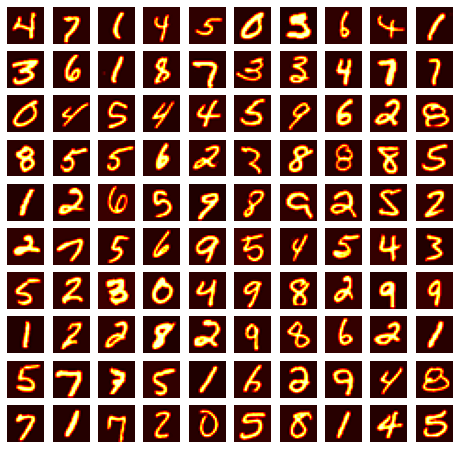

In [3]:
fig,axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap="hot")
        axis[i,j].axis("off")

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
def sigmoidGradient(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [6]:
def createTheta(theta,input_layer_size,hidden_layer_size,num_labels):
    # Cria lista com os vetores theta de cada camada escondida
    n_layers = hidden_layers_size.shape[0]
    thetan = []
    thetan.append(theta[:((input_layer_size+1)*hidden_layers_size[0])].reshape(hidden_layers_size[0],input_layer_size+1))
    aux_begin = ((input_layer_size+1)*hidden_layers_size[0])
    aux_end = 0
    if(n_layers > 1):
        for i in range(hidden_layers_size.shape[0]-1):
            aux_end = aux_begin + (hidden_layers_size[i]+1)*hidden_layers_size[i+1]
            thetan.append(theta[aux_begin:aux_end].reshape(hidden_layers_size[i+1],hidden_layers_size[i]+1))
            aux_begin = aux_end
    else:
        aux_end = ((input_layer_size+1)*hidden_layers_size[-1])
    thetan.append(theta[aux_end:].reshape(num_labels,hidden_layers_size[-1]+1))
    return thetan

In [7]:
def computeCost(X,y,theta,input_layer_size,hidden_layer_size,num_labels, Lambda):
    
    thetan = createTheta(theta,input_layer_size,hidden_layer_size,num_labels)
        
    m = X.shape[0]
    J = 0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    an = []
    an.append(sigmoid(X @ thetan[0].T))
    an[0] = np.hstack((np.ones((m,1)),an[0]))
    for i in range(len(thetan)-1):
        an.append(sigmoid(an[i] @ thetan[i+1].T))

        
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j]*np.log(an[-1][:,j])-(1-y10[:,j])*np.log(1-an[-1][:,j]))
       
    cost = 1/m*J
    aux = 0
    for i in range(len(thetan)):
        aux = aux + np.sum(thetan[i][:,1:]**2)
    reg_J = cost + Lambda/(2*m)*(aux)
    
    grad = []
    grad_reg = []
    for i in range(len(thetan)):
        grad.append(np.zeros((thetan[i].shape)))

    for i in range(m):
        xi = X[i,:]
        ani = []
        dn = []
        for j in range(len(an)):
            ani.append(an[j][i,:])
            
    
        dn.append(ani[-1] - y10[i,:])
        for j in range(len(thetan)-1):   
            aux = thetan[len(thetan)-1-j].T @ dn[len(thetan)-1-(j+1)].T * sigmoidGradient(np.hstack((1,xi @ thetan[len(thetan)-1-(j+1)].T)))
            dn.insert(0,aux)
                         
        grad[0] = grad[0] + dn[0][1:][:,np.newaxis]@xi[:,np.newaxis].T
        for j in range(len(thetan)-1):
            grad[j+1] = grad[j+1] + dn[j+1].T[:,np.newaxis]@ani[j][:,np.newaxis].T
    
    for j in range(len(grad)):                        
        grad[j] = 1/m*grad[j]
    for j in range(len(grad)):
        grad_reg.append(grad[j] + (Lambda/m)*np.hstack((np.zeros((thetan[j].shape[0],1)),thetan[j][:,1:])))
    
                                 
    return cost,grad,reg_J,grad_reg

In [8]:
def randInitializeWeights(L_in,L_out):
    epi = (6**1/2)/(L_in+L_out)**1/2
    W = np.random.rand(L_out,L_in+1)*(2*epi)-epi
    return W

In [26]:
def gradientDescent(X,y,theta,alpha,nbr_iter,Lambda,input_layer_size,hidden_layer_size,num_labels):

    thetan = createTheta(theta,input_layer_size,hidden_layer_size,num_labels)
    
    m = len(y)
    J_history = []
    theta_n = []
    for i in range(nbr_iter):
        for j in range(len(thetan)-1):
            theta_n = np.append(thetan[0].flatten(),thetan[j+1].flatten())
            
        cost,grad = computeCost(X,y,theta_n,input_layer_size,hidden_layer_size,num_labels,Lambda)[2:]#problema
        
        for j in range(len(thetan)): 
            thetan[j] = thetan[j] - (alpha*grad[j])
        J_history.append(cost)
        
    nn_paramsFinal = thetan
    return nn_paramsFinal,J_history

In [27]:
def prediction(X,thetan):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    an = [];
    an.append(sigmoid(X @ thetan[0].T))
    an[0] = np.hstack((np.ones((m,1)),an[0]))
    for i in range(len(thetan)-1):
        an.append(sigmoid(an[i] @ thetan[i+1].T))   

    return np.argmax(an[-1],axis=1)+1

In [28]:
input_layer_size = 400
hidden_layers_size = np.array([25])#Array com as mamadas escondidas e suas respectivas quantidades de neurônios
num_labels = 10
n_layers = hidden_layers_size.shape[0]

p = 0
initial_theta1 = randInitializeWeights(input_layer_size,hidden_layers_size[0])
if(n_layers > 1):
    for i in range(hidden_layers_size.shape[0]-1):
        aux_theta = randInitializeWeights(hidden_layers_size[i],hidden_layers_size[i+1])
        initial_theta1 = np.append(initial_theta1.flatten(),aux_theta.flatten())
        p = i+1
initial_theta2 = randInitializeWeights(hidden_layers_size[p],num_labels)
initial_theta = np.append(initial_theta1.flatten(),initial_theta2.flatten())


theta,J_history = gradientDescent(X,y,initial_theta,0.8,800,1,input_layer_size,hidden_layers_size,num_labels)


In [29]:
pred = prediction(X,theta)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

[[ 8.43206194e-02 -8.14492633e-04 -2.36796975e-03 ... -2.91153827e-03
   2.49124962e-03 -7.57442293e-05]
 [-6.79310799e-01 -2.92717548e-03  1.07735525e-04 ... -1.91781205e-03
   2.46750714e-04 -1.30237400e-03]
 [-5.44799158e-02 -9.69383170e-04  8.67832682e-04 ... -1.21793172e-03
  -2.14989523e-03  2.87910045e-03]
 ...
 [-5.96277552e-02  2.40904974e-03  2.67642654e-04 ...  2.00844728e-03
   2.91692137e-03  8.63522868e-04]
 [-3.64934234e-01  2.02192425e-03 -1.15862501e-03 ...  1.83033068e-03
   1.93093769e-03  1.02836783e-04]
 [-2.62053242e-02  4.39549641e-04  1.60998429e-03 ... -3.21902078e-04
  -6.47337883e-04  8.49642586e-04]]
Training Set Accuracy: 94.22 %
